# Quantile Power Law Analysis

## Overview

This notebook performs a Quantile Power Law Analysis on Bitcoin's historical price data. 
We begin by aggregating minute-level data to daily prices, then explore the relationship 
between Bitcoin's price and time since its genesis using log-log plots. 

Quantile regression is applied to capture the variability in price movements across different 
quantiles, providing a robust statistical framework for understanding Bitcoin's price dynamics. 

We further analyze the impact of Bitcoin halving events and use machine learning models to 
predict significant price movements based on quantile positioning and halving cycles. 
Visualizations and detailed quantile analyses are included to support our findings.

In [39]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import kagglehub



In [40]:
# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")
path

'/Users/praveen/.cache/kagglehub/datasets/mczielinski/bitcoin-historical-data/versions/318'

In [41]:
# Set the path to the file you'd like to load
file_path = f"{path}/btcusd_1-min_data.csv"

In [42]:
#Read the file
df= pd.read_csv(file_path)

In [43]:
#Check the first few rows of the dataframe
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


We will study the data summarising at a daily level. We don't need minute by minute data for this analysis. Daily data is sufficient

In [44]:
# Convert Timestamp to datetime if not already
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s').dt.date

# Aggregate to daily data
daily_df = df.groupby('Date').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).reset_index()

daily_df.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-01,4.58,4.84,4.58,4.84,10.000000
1,2012-01-02,4.84,5.00,4.84,5.00,10.100000
2,2012-01-03,5.00,5.32,5.00,5.29,107.085281
3,2012-01-04,5.29,5.57,4.93,5.57,107.233260
4,2012-01-05,5.57,6.46,5.57,6.42,70.328742


We will now plot the price against date|

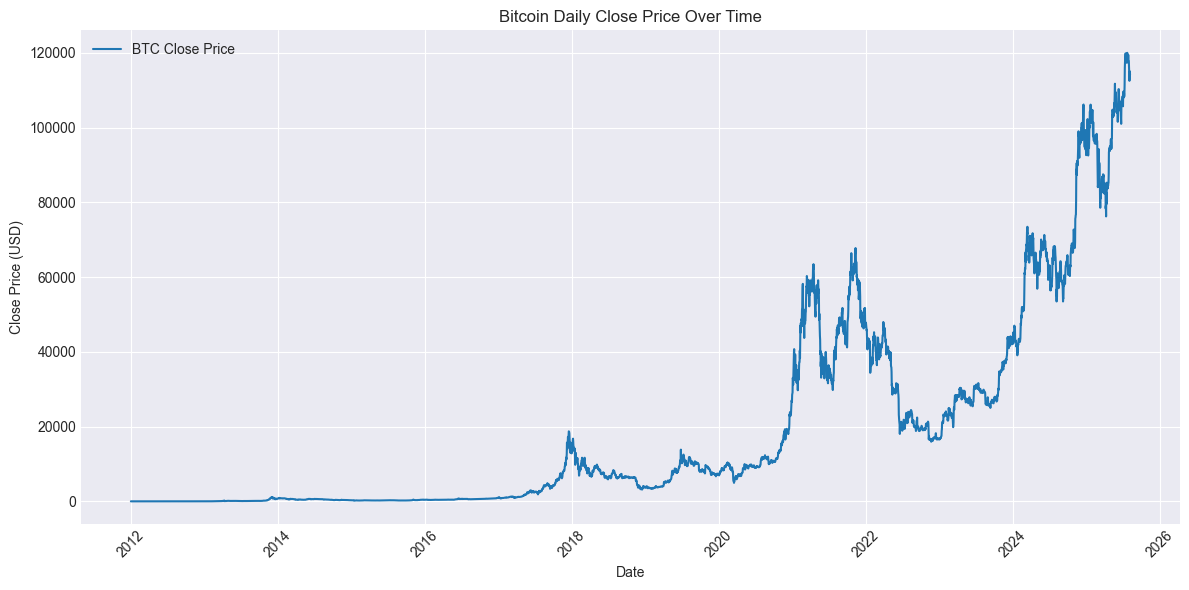

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(daily_df['Date'], daily_df['Close'], label='BTC Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Bitcoin Daily Close Price Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Power Law

The Power Law is a functional relationship where one quantity varies as a power of another. In the context of Bitcoin price analysis, plotting the price against time on a log-log scale often reveals a linear relationship, suggesting that Bitcoin's price growth may follow a power law over time. This behavior is common in complex systems and financial markets, indicating scale invariance and the presence of underlying multiplicative processes.

We will now study the data power on the log-log chart. First we set the bitcoin genesis day

In [46]:
#Set bitcoin_genesis date
bitcoin_genesis_date = pd.to_datetime("2010-01-03")

In [47]:
# Add a column for days since Bitcoin Genesis
daily_df['DaysSinceGenesis'] = (pd.to_datetime(daily_df['Date']) - bitcoin_genesis_date).dt.days

In [48]:
daily_df.head() 

,Date,Open,High,Low,Close,Volume,DaysSinceGenesis
0,2012-01-01,4.58,4.84,4.58,4.84,10.000000,728
1,2012-01-02,4.84,5.00,4.84,5.00,10.100000,729
2,2012-01-03,5.00,5.32,5.00,5.29,107.085281,730
3,2012-01-04,5.29,5.57,4.93,5.57,107.233260,731
4,2012-01-05,5.57,6.46,5.57,6.42,70.328742,732


We will add columns for log of the close price and number of days since genesis of the first block

In [49]:
daily_df["log_Close"] = np.log(daily_df["Close"])
daily_df["log_days_since_genesis"] = np.log(daily_df["DaysSinceGenesis"])

We will now plot the data on the log-log scale where we see the data forms a straight line

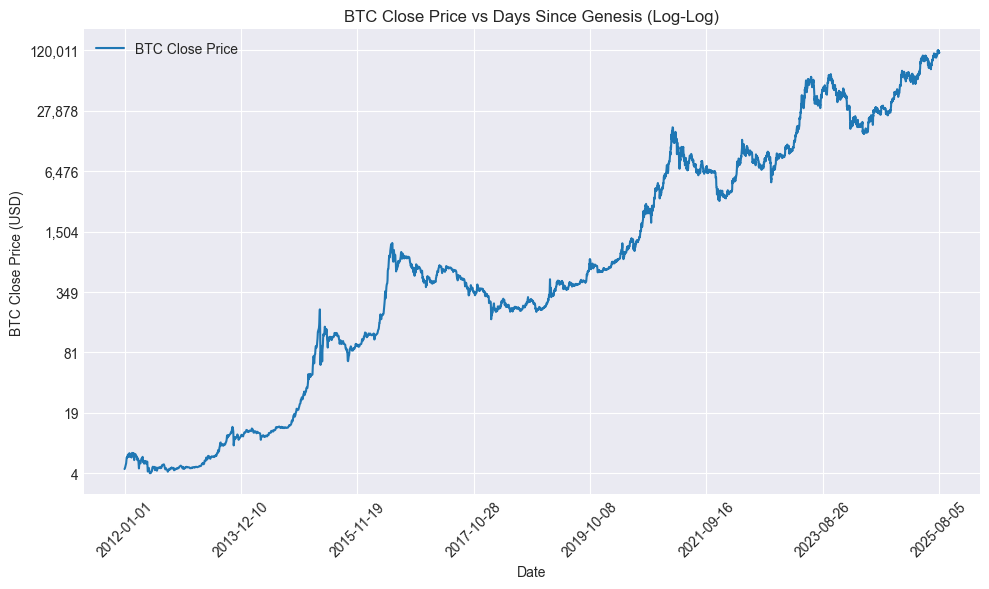

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot log-log data
ax.plot(daily_df['log_days_since_genesis'], daily_df['log_Close'], label='BTC Close Price')

# Set x-ticks to show dates
xticks = np.linspace(daily_df['log_days_since_genesis'].min(), daily_df['log_days_since_genesis'].max(), 8)
xtick_labels = pd.to_datetime(daily_df['Date'].iloc[np.linspace(0, len(daily_df)-1, 8, dtype=int)]).dt.strftime('%Y-%m-%d')
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45)

# Set y-ticks to show prices
yticks = np.linspace(daily_df['log_Close'].min(), daily_df['log_Close'].max(), 8)
ytick_labels = [f"{np.exp(y):,.0f}" for y in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

ax.set_xlabel('Date')
ax.set_ylabel('BTC Close Price (USD)')
ax.set_title('BTC Close Price vs Days Since Genesis (Log-Log)')
ax.legend()
plt.tight_layout()
plt.show()

### Linear Regression with log-log data

We will now explore the linear regression on the log-log data and associated metrics

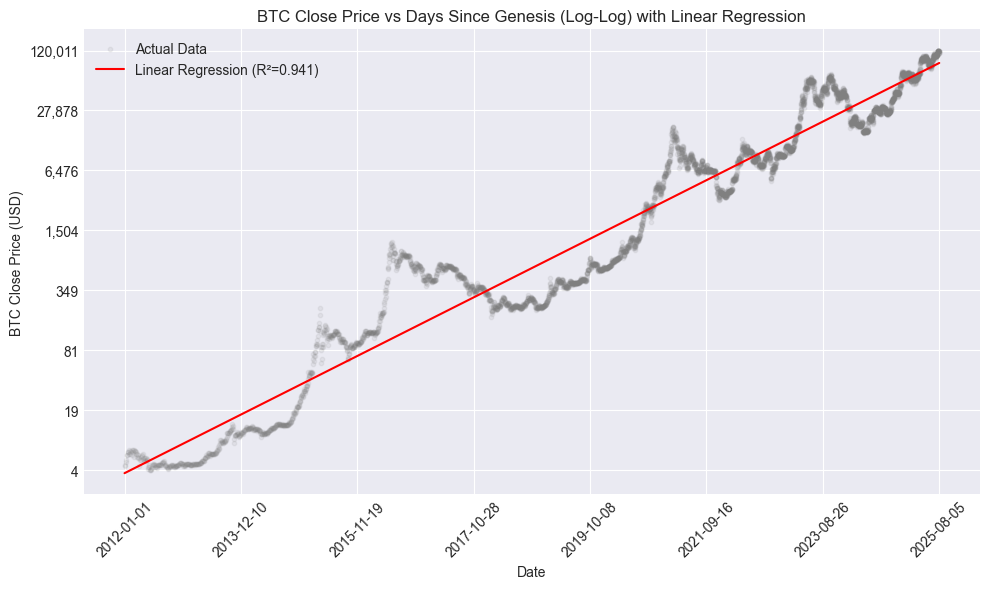

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare data for regression
X_lin = daily_df[['log_days_since_genesis']].values
y_lin = daily_df['log_Close'].values

# Fit linear regression
linreg = LinearRegression()
linreg.fit(X_lin, y_lin)
y_pred = linreg.predict(X_lin)
score = r2_score(y_lin, y_pred)

# Plot actual data and regression line
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(daily_df['log_days_since_genesis'], daily_df['log_Close'], label='Actual Data', color='grey', alpha=0.1, s=10)
ax.plot(daily_df['log_days_since_genesis'], y_pred, color='red', label=f'Linear Regression (R²={score:.3f})')

# Set x-ticks and y-ticks as before
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45)
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

ax.set_xlabel('Date')
ax.set_ylabel('BTC Close Price (USD)')
ax.set_title('BTC Close Price vs Days Since Genesis (Log-Log) with Linear Regression')
ax.legend()
plt.tight_layout()
plt.show()

## Quantile Analysis

### Quantile Regression Summary

Quantile regression is a statistical technique that estimates the relationship between independent variables and specific quantiles (percentiles) of the dependent variable, rather than focusing solely on the mean as in ordinary least squares regression. This approach provides a more comprehensive view of the possible outcomes and their distribution.

In financial data analysis, quantile regression is particularly valuable because financial returns and prices often exhibit heavy tails, outliers, and heteroscedasticity (changing variance). By modeling different quantiles, analysts can better understand the behavior of asset prices under various market conditions, assess risk, and identify factors influencing extreme movements (such as large gains or losses). This makes quantile regression a robust tool for capturing the full range of potential outcomes in volatile financial markets like cryptocurrencies.

In [52]:
import statsmodels.api as sm


# Drop any rows with NaN values
daily_df.dropna(subset=["log_Close", "log_days_since_genesis"], inplace=True)

Y = daily_df["log_Close"]
X = daily_df["log_days_since_genesis"]

# Add a constant to the independent variable for the intercept
X_const = sm.add_constant(X)

# Define the quantiles to be used
quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

quantile_regression_results = {}

for q in quantiles:
    # Fit the QuantReg model
    quant_reg_model = sm.QuantReg(Y, X_const).fit(q=q)
    
    # Store the parameters (intercept and slope)
    quantile_regression_results[str(q)] = {
        "intercept": quant_reg_model.params["const"],
        "slope": quant_reg_model.params["log_days_since_genesis"],
        "summary": quant_reg_model.summary().as_text() # Storing full summary for reference
    }


Printing the quantiles here.

In [53]:
print("Quantile Regression Results:")
for q, res in quantile_regression_results.items():
    print(f"Quantile: {q}")
    print(f"Intercept: {res['intercept']}")
    print(f"Slope: {res['slope']}")
    print(f"Summary:\n{res['summary']}")

Quantile Regression Results:
Quantile: 0.01
Intercept: -34.21151084963003
Slope: 5.191584083305202
Summary:
                         QuantReg Regression Results                          
Dep. Variable:              log_Close   Pseudo R-squared:               0.8502
Model:                       QuantReg   Bandwidth:                      0.2337
Method:                 Least Squares   Sparsity:                        4.157
Date:                Wed, 06 Aug 2025   No. Observations:                 4966
Time:                        07:47:57   Df Residuals:                     4964
                                        Df Model:                            1
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -34.2115      0.065   -524.830      0.000     -34.339     -34.084
log_days_since_genesis     5.1916      0.008    635.404      0.000

Plotting the quantiles for visualisation

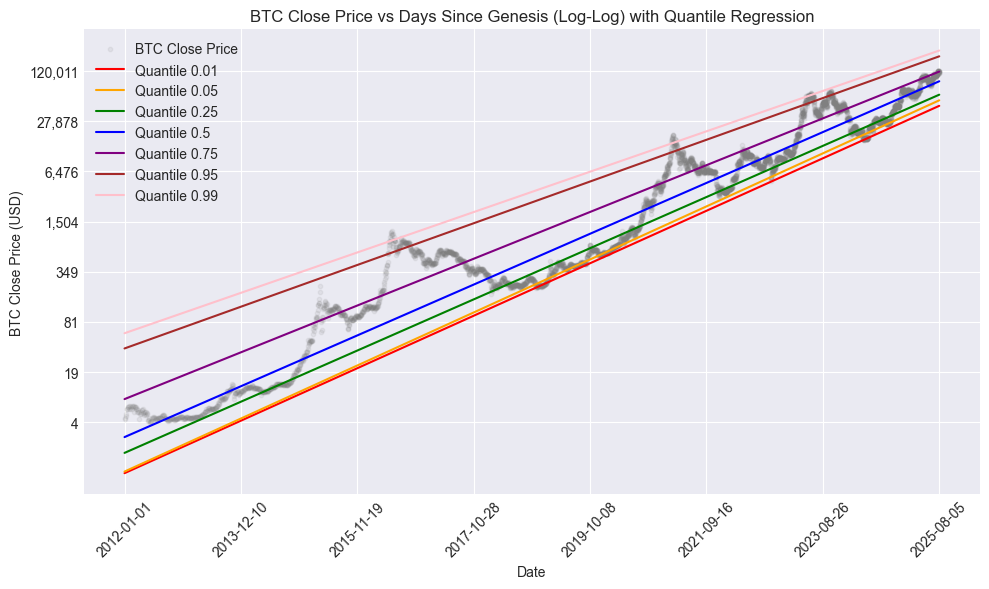

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use("seaborn-v0_8-darkgrid")

# Plot the actual log-log data
ax.scatter(daily_df['log_days_since_genesis'], daily_df['log_Close'], label='BTC Close Price', color='grey', alpha=0.1, s=10)

# Plot quantile regression lines
quantile_colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown', 'pink']
for i, q in enumerate(quantiles):
    intercept = quantile_regression_results[str(q)]['intercept']
    slope = quantile_regression_results[str(q)]['slope']
    y_pred = intercept + slope * daily_df['log_days_since_genesis']
    ax.plot(daily_df['log_days_since_genesis'], y_pred, label=f'Quantile {q}', color=quantile_colors[i % len(quantile_colors)])

# Set x-ticks to show dates
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45)

# Set y-ticks to show prices
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

ax.set_xlabel('Date')
ax.set_ylabel('BTC Close Price (USD)')
ax.set_title('BTC Close Price vs Days Since Genesis (Log-Log) with Quantile Regression')
ax.legend()
plt.tight_layout()
plt.show()

We will now plot the quantile regressions in normal price and date, without logs.

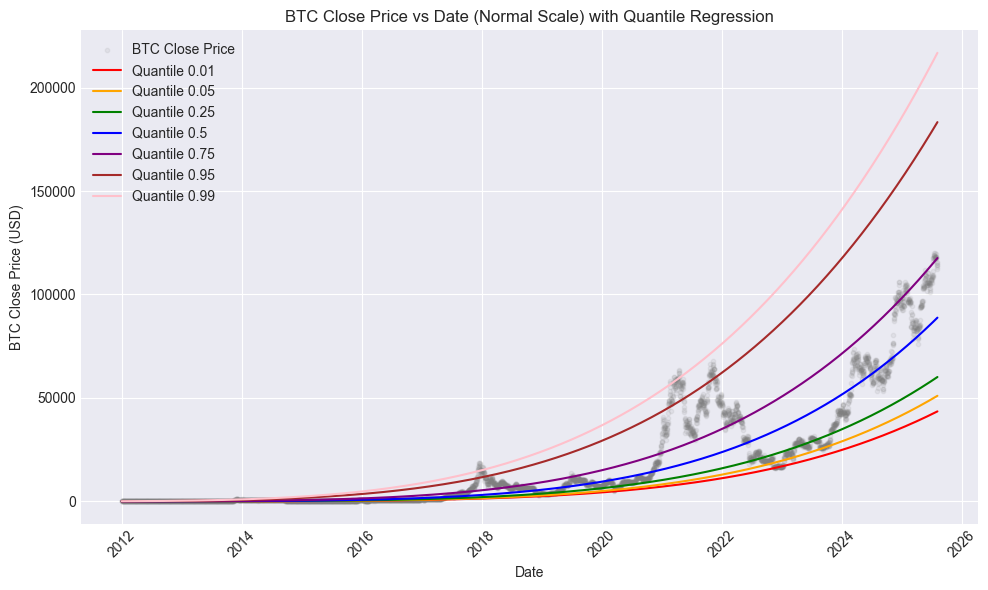

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use("seaborn-v0_8-darkgrid")

# Plot the actual data (normal scale)
ax.scatter(daily_df['Date'], daily_df['Close'], label='BTC Close Price', color='grey', alpha=0.1, s=10)

# Plot quantile regression lines (convert predictions back to normal scale)
for i, q in enumerate(quantiles):
    intercept = quantile_regression_results[str(q)]['intercept']
    slope = quantile_regression_results[str(q)]['slope']
    y_pred = np.exp(intercept + slope * daily_df['log_days_since_genesis'])
    ax.plot(daily_df['Date'], y_pred, label=f'Quantile {q}', color=quantile_colors[i % len(quantile_colors)])

ax.set_xlabel('Date')
ax.set_ylabel('BTC Close Price (USD)')
ax.set_title('BTC Close Price vs Date (Normal Scale) with Quantile Regression')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [56]:
# Show the latest predicted value for each quantile (for the last row in daily_df)
latest_log_days = daily_df['log_days_since_genesis'].iloc[-1]
latest_preds = {}

for q in quantiles:
    intercept = quantile_regression_results[str(q)]['intercept']
    slope = quantile_regression_results[str(q)]['slope']
    log_pred = intercept + slope * latest_log_days
    price_pred = np.exp(log_pred)
    latest_preds[q] = price_pred

# Display as a DataFrame for easier viewing
latest_quantile_preds = pd.DataFrame({
    'Quantile': list(latest_preds.keys()),
    'Predicted_Close': list(latest_preds.values())
})
print(latest_quantile_preds)

   Quantile  Predicted_Close
0      0.01     43480.961356
1      0.05     51018.949915
2      0.25     60099.874983
3      0.50     88790.670741
4      0.75    117605.906101
5      0.95    183315.159838
6      0.99    216810.321707


### Detailed Quantiles 

In this section we add quantiles for every entry. We will now get quantiles between 0.01 to 0.99 with steps of 0.01. With this we will be able to look at recent data and identify the quantile it falls in. This can be used as a metric to see if current value is higher or lower based on historic data

In [57]:
quantiles = np.arange(0.01, 1.00, 0.01)

In [58]:
quantile_regression_results = {}

for q in quantiles:
    # Fit the QuantReg model
    quant_reg_model = sm.QuantReg(Y, X_const).fit(q=q)
    
    # Store the parameters (intercept and slope)
    quantile_regression_results[str(q)] = {
        "intercept": quant_reg_model.params["const"],
        "slope": quant_reg_model.params["log_days_since_genesis"],
        "summary": quant_reg_model.summary().as_text() # Storing full summary for reference
    }

We will now match each value to it closest quantile

In [59]:
# Compute predicted log_Close for each quantile at each day
log_close_preds = np.zeros((len(daily_df), len(quantiles)))
for idx, q in enumerate(quantiles):
    intercept = quantile_regression_results[str(q)]['intercept']
    slope = quantile_regression_results[str(q)]['slope']
    log_close_preds[:, idx] = intercept + slope * daily_df['log_days_since_genesis']

# Find the closest quantile for each day's actual log_Close
closest_quantile_indices = np.abs(log_close_preds - daily_df['log_Close'].values[:, None]).argmin(axis=1)
closest_quantiles = quantiles[closest_quantile_indices]

# Add the closest quantile as a new column
daily_df['closest_quantile'] = closest_quantiles

In [60]:
daily_df.tail()

,Date,Open,High,Low,Close,Volume,DaysSinceGenesis,log_Close,log_days_since_genesis,closest_quantile
4961,2025-08-01,115749.0,116054.0,112680.0,113243.0,2329.787439,5689,11.637291,8.646290,0.71
4962,2025-08-02,113243.0,114008.0,111987.0,112522.0,1093.670894,5690,11.630904,8.646466,0.71
4963,2025-08-03,112522.0,114774.0,111919.0,114226.0,757.708175,5691,11.645934,8.646641,0.72
4964,2025-08-04,114245.0,115732.0,114129.0,115051.0,933.276509,5692,11.653131,8.646817,0.73
4965,2025-08-05,115051.0,115106.0,112660.0,114134.0,941.792015,5693,11.645128,8.646993,0.72


### Halving

To model the cyclicity of bitcoin we add the number of days since last halving or genesis

In [61]:
# Define Bitcoin halving dates (source: https://en.bitcoin.it/wiki/Controlled_supply)
halving_dates = [
    pd.to_datetime("2009-01-09"),  # Bitcoin Genesis Block
    pd.to_datetime("2012-11-28"),
    pd.to_datetime("2016-07-09"),
    pd.to_datetime("2020-05-11"),
    pd.to_datetime("2024-04-19"),
    # Add future halving dates if needed
]

# Convert 'Date' column to datetime if not already
daily_df['Date'] = pd.to_datetime(daily_df['Date'])

# Find the most recent halving for each date
def days_since_last_halving(date):
    past_halvings = [d for d in halving_dates if d <= date]
    if past_halvings:
        last_halving = max(past_halvings)
        return (date - last_halving).days
    else:
        return (date - halving_dates[0]).days  # Before first halving

daily_df['days_since_last_halving'] = daily_df['Date'].apply(days_since_last_halving)

In [62]:
daily_df.head()

,Date,Open,High,Low,Close,Volume,DaysSinceGenesis,log_Close,log_days_since_genesis,closest_quantile,days_since_last_halving
0,2012-01-01,4.58,4.84,4.58,4.84,10.000000,728,1.576915,6.590301,0.60,1087
1,2012-01-02,4.84,5.00,4.84,5.00,10.100000,729,1.609438,6.591674,0.61,1088
2,2012-01-03,5.00,5.32,5.00,5.29,107.085281,730,1.665818,6.593045,0.62,1089
3,2012-01-04,5.29,5.57,4.93,5.57,107.233260,731,1.717395,6.594413,0.63,1090
4,2012-01-05,5.57,6.46,5.57,6.42,70.328742,732,1.859418,6.595781,0.69,1091


### Prediction for the next week

We will now make a simple model to check how the price will vary next week. Our model will tell us if the prices next week can increase and/ or decrease by 5% next week

We will add 2 columns in our data frame. One is true is the price exceeds 5% from close today else is false. Conversely the next column will be true if the price falls by 5% anytime in the next 7 days. Please note that both cases can happen in the same week

In [63]:
# Calculate 5p and 5n columns for daily_df
future_window = 7

# Get the Close price as numpy array for efficiency
close_prices = daily_df['Close'].values

# Initialize arrays
five_p = np.zeros(len(daily_df), dtype=bool)
five_n = np.zeros(len(daily_df), dtype=bool)

for i in range(len(daily_df) - future_window):
    future = close_prices[i+1:i+1+future_window]
    current = close_prices[i]
    # 5p: price increases by more than 5% anytime in next 7 days
    if np.any(future > current * 1.05):
        five_p[i] = True
    # 5n: price decreases by more than 5% anytime in next 7 days
    if np.any(future < current * 0.95):
        five_n[i] = True

# Add to dataframe
daily_df['5p'] = five_p
daily_df['5n'] = five_n

We will add one more column for the 7-day running quantile to feed the model an indication of the data across past few days.

In [64]:
# Calculate the rolling (moving) quantile for the last 7 days using the 'closest_quantile' column
daily_df['moving_quantile_7d'] = daily_df['closest_quantile'].rolling(window=7, min_periods=1).mean()

In [65]:
daily_df.head()

,Date,Open,High,Low,Close,Volume,DaysSinceGenesis,log_Close,log_days_since_genesis,closest_quantile,days_since_last_halving,5p,5n,moving_quantile_7d
0,2012-01-01,4.58,4.84,4.58,4.84,10.000000,728,1.576915,6.590301,0.60,1087,True,False,0.600
1,2012-01-02,4.84,5.00,4.84,5.00,10.100000,729,1.609438,6.591674,0.61,1088,True,False,0.605
2,2012-01-03,5.00,5.32,5.00,5.29,107.085281,730,1.665818,6.593045,0.62,1089,True,False,0.610
3,2012-01-04,5.29,5.57,4.93,5.57,107.233260,731,1.717395,6.594413,0.63,1090,True,False,0.615
4,2012-01-05,5.57,6.46,5.57,6.42,70.328742,732,1.859418,6.595781,0.69,1091,True,False,0.630


In [66]:
daily_df.tail()

,Date,Open,High,Low,Close,Volume,DaysSinceGenesis,log_Close,log_days_since_genesis,closest_quantile,days_since_last_halving,5p,5n,moving_quantile_7d
4961,2025-08-01,115749.0,116054.0,112680.0,113243.0,2329.787439,5689,11.637291,8.646290,0.71,469,False,False,0.760000
4962,2025-08-02,113243.0,114008.0,111987.0,112522.0,1093.670894,5690,11.630904,8.646466,0.71,470,False,False,0.751429
4963,2025-08-03,112522.0,114774.0,111919.0,114226.0,757.708175,5691,11.645934,8.646641,0.72,471,False,False,0.741429
4964,2025-08-04,114245.0,115732.0,114129.0,115051.0,933.276509,5692,11.653131,8.646817,0.73,472,False,False,0.735714
4965,2025-08-05,115051.0,115106.0,112660.0,114134.0,941.792015,5693,11.645128,8.646993,0.72,473,False,False,0.728571


#### Model with Decision Tree

We will now build a model to predict if the pricing will increase or decrease in the next 7 days. The parameters we use are current quantile, number of days since last halving and moving 7 days quantile. 

In [67]:
X= daily_df[['closest_quantile', 'days_since_last_halving', 'moving_quantile_7d']]
Y_p = daily_df['5p'].astype(int)  # Convert boolean to int for regression
Y_n = daily_df['5n'].astype(int)  # Convert boolean to int for regression

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [69]:
# We will standardize the features for better performance
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

Train to test split is 70:30 

In [70]:
X_train, X_test, y_p5_train, y_p5_test = train_test_split(X_standardized, Y_p, test_size=0.3, random_state=42)
X_train, X_test, y_n5_train, y_n5_test = train_test_split(X_standardized, Y_n, test_size=0.3, random_state=42)

In [71]:
rf_p5 = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=2, max_features='sqrt')
rf_p5.fit(X_train, y_p5_train)
rf_n5 = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=2, max_features='sqrt')
rf_n5.fit(X_train, y_n5_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [72]:
# Calculate accuracy for Random Forest p5
rf_p5_train_accuracy = rf_p5.score(X_train, y_p5_train)
rf_p5_test_accuracy = rf_p5.score(X_test, y_p5_test)
print(f"Random Forest Training Accuracy for p5: {rf_p5_train_accuracy * 100:.2f}%")
print(f"Random Forest Test Accuracy for p5: {rf_p5_test_accuracy * 100:.2f}%")

# Calculate accuracy for Random Forest n5
rf_n5_train_accuracy = rf_n5.score(X_train, y_n5_train)
rf_n5_test_accuracy = rf_n5.score(X_test, y_n5_test)
print(f"Random Forest Training Accuracy for n5: {rf_n5_train_accuracy * 100:.2f}%")
print(f"Random Forest Test Accuracy for n5: {rf_n5_test_accuracy * 100:.2f}%")

Random Forest Training Accuracy for p5: 83.98%
Random Forest Test Accuracy for p5: 72.28%
Random Forest Training Accuracy for n5: 85.73%
Random Forest Test Accuracy for n5: 78.93%


We will now look at the most recent data and see what is in store for next week

In [73]:
last_nonscaled = X.iloc[-1:]
last_nonscaled

,closest_quantile,days_since_last_halving,moving_quantile_7d
4965,0.72,473,0.728571


In [74]:
print("Current Quantile:", last_nonscaled['closest_quantile'].values[0])

Current Quantile: 0.72


In [75]:
# Predict the last entry in X_standardized using all trained models
last_entry = X_standardized[-1].reshape(1, -1)

last_entry

array([[ 0.76202231, -0.50764422,  0.79412267]])

In [76]:


# Random Forest predictions
rf_p5_prediction = rf_p5.predict(last_entry)
rf_n5_prediction = rf_n5.predict(last_entry)
print(f"Prediction for price increaseing by 5% in the next week: {rf_p5_prediction[0]}")
print(f"Prediction for price decreaseing by 5% in the next week: {rf_n5_prediction[0]}")

Prediction for price increaseing by 5% in the next week: 0
Prediction for price decreaseing by 5% in the next week: 0
